## Import

In [2]:
# 표준 라이브러리
import os
import random

# 데이터 처리 및 분석 라이브러리
import numpy as np
import pandas as pd
import duckdb

# 진행상황 표시 라이브러리
from tqdm import tqdm

## Data Load

In [7]:
train = duckdb.query("""
    SELECT * EXCLUDE seq
    FROM '../data/train.parquet'
""").to_df()
train.head()

,gender,age_group,inventory_id,day_of_week,hour,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,36,5,13,1.0,2.0,1.0,23.0,1.0,...,0.070092,0.070092,0.011682,0.004673,0.087226,0.049843,0.015576,0.040498,0.051401,0
1,1.0,7.0,2,5,08,2.0,2.0,3.0,17.0,193.0,...,0.072990,0.072990,0.012165,0.004866,0.045416,0.051904,0.016220,0.042172,0.026763,0
2,1.0,7.0,36,5,11,1.0,2.0,1.0,7.0,675.0,...,0.057177,0.057177,0.009530,0.003812,0.035577,0.081318,0.012706,0.033036,0.062898,0
3,1.0,8.0,37,5,11,2.0,2.0,2.0,7.0,294.0,...,0.100449,0.100449,0.016741,0.006697,0.062502,0.071430,0.022322,0.058037,0.073659,0
4,2.0,7.0,37,5,07,2.0,2.0,3.0,24.0,497.0,...,0.064512,0.064512,0.010752,0.004301,0.040141,0.045875,0.014336,0.037274,0.023654,0


In [8]:
test = duckdb.query("""
    SELECT * EXCLUDE seq
    FROM '../data/test.parquet'
""").to_df()
test = test.drop(columns='ID')
test.head()

,gender,age_group,inventory_id,day_of_week,hour,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,...,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30
0,2.0,6.0,46,7,13,2.0,2.0,2.0,19.0,1047.0,...,0.008702,0.071199,0.071199,0.011866,0.004747,0.044302,0.050630,0.015822,0.041137,0.104432
1,2.0,8.0,29,7,21,2.0,2.0,2.0,7.0,1024.0,...,0.024553,0.200889,0.200889,0.033482,0.013393,0.124998,0.142854,0.044642,0.116069,0.073659
2,1.0,6.0,37,7,19,2.0,2.0,3.0,7.0,562.0,...,0.021739,0.177867,0.177867,0.029645,0.011858,0.110673,0.126483,0.039526,0.102768,0.065218
3,2.0,7.0,41,7,09,2.0,2.0,2.0,7.0,444.0,...,0.006614,0.108234,0.054117,0.009019,0.003608,0.033673,0.038483,0.012026,0.031268,0.039686
4,1.0,8.0,2,7,18,2.0,2.0,3.0,8.0,709.0,...,0.006532,0.053442,0.053442,0.008907,0.003563,0.033253,0.038003,0.011876,0.030878,0.039191


In [10]:
print(train.shape)
print(test.shape)

(10704179, 118)
(1527298, 117)


# EDA

In [12]:
print(train.isna().sum())
print(test.isna().sum())

gender          17208
age_group       17208
inventory_id        0
day_of_week         0
hour                0
                ...  
history_b_27    17208
history_b_28    17208
history_b_29    17208
history_b_30    17208
clicked             0
Length: 118, dtype: int64
gender          936
age_group       936
inventory_id      0
day_of_week       0
hour              0
               ... 
history_b_26    936
history_b_27    936
history_b_28    936
history_b_29    936
history_b_30    936
Length: 117, dtype: int64


In [13]:
train_clean = train.dropna()
test_clean = test.dropna()

In [14]:
print(train_clean.isna().sum())
print(test_clean.isna().sum())
print(train_clean.shape)
print(test_clean.shape)

gender          0
age_group       0
inventory_id    0
day_of_week     0
hour            0
               ..
history_b_27    0
history_b_28    0
history_b_29    0
history_b_30    0
clicked         0
Length: 118, dtype: int64
gender          0
age_group       0
inventory_id    0
day_of_week     0
hour            0
               ..
history_b_26    0
history_b_27    0
history_b_28    0
history_b_29    0
history_b_30    0
Length: 117, dtype: int64
(9611653, 118)
(1434828, 117)


In [15]:
train_clean['clicked'].value_counts()
# 클래스 불균형 크다. 샘플링 해줘야할듯 

clicked
0    9428464
1     183189
Name: count, dtype: int64

## 모델링

In [16]:
from sklearn.model_selection import train_test_split
train_clean_x = train_clean.drop(columns='clicked')
train_clean_y = train_clean['clicked']
print(train_clean_x)
print(train_clean_y)


         gender age_group inventory_id day_of_week hour  l_feat_1  l_feat_2  \
0           1.0       7.0           36           5   13       1.0       2.0   
1           1.0       7.0            2           5   08       2.0       2.0   
2           1.0       7.0           36           5   11       1.0       2.0   
3           1.0       8.0           37           5   11       2.0       2.0   
4           2.0       7.0           37           5   07       2.0       2.0   
...         ...       ...          ...         ...  ...       ...       ...   
10704174    1.0       6.0           29           5   20       2.0       2.0   
10704175    1.0       8.0           36           5   13       1.0       2.0   
10704176    1.0       8.0            2           5   07       2.0       2.0   
10704177    1.0       7.0            2           5   12       2.0       2.0   
10704178    1.0       7.0           31           5   23       2.0       2.0   

          l_feat_3  l_feat_4  l_feat_5  ...  histor

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(
    train_clean_x,train_clean_y,
    test_size=0.1,
    random_state=42,
    stratify = train_clean_y
)

In [19]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(8650487, 117)
(8650487,)
(961166, 117)
(961166,)


In [27]:
cols = ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour'] 

def to_int_df(df, columns):
    for c in columns:
        if c not in df.columns:
            continue
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1).astype('int64')
    return df

X_train = to_int_df(X_train, cols)
X_val   = to_int_df(X_val, cols)

In [42]:
test = to_int_df(test,cols)

In [37]:
# 3) 모델 파라미터 (GPU + 안정화)
ratio = 9428464 / 183189  # ≈ 51.5

model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=ratio,
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=255,
    max_bin=255,                
    min_data_in_bin=1,           
    min_data_in_leaf=20,         
    min_sum_hessian_in_leaf=1e-3,
    device_type='gpu',           
    gpu_use_dp=True              
)

model.fit(
    X_train, Y_train,
    eval_set=[(X_val, Y_val)],
    eval_metric='auc'
)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Info] Number of positive: 164870, number of negative: 8485617
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 17711
[LightGBM] [Info] Number of data points in the train set: 8650487, number of used features: 117
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size

,boosting_type,'gbdt'
,num_leaves,255
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [38]:
preds = model.predict_proba(X_val)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001


Validation AUC: 0.7352


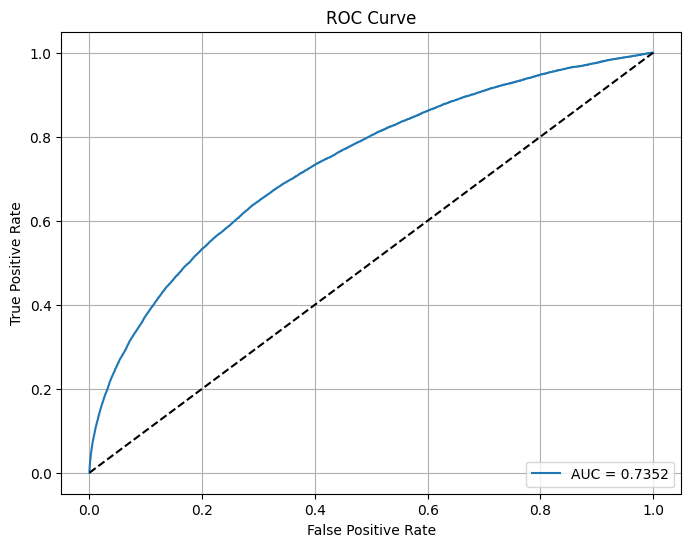

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. AUC 점수 계산
auc_score = roc_auc_score(Y_val, preds)
print(f'Validation AUC: {auc_score:.4f}')

# 2. ROC 곡선 시각화
fpr, tpr, thresholds = roc_curve(Y_val, preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--') # 50% 수준의 랜덤 모델
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [43]:
test_preds = model.predict_proba(test)[:, 1]


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001


# submission

In [44]:
submit = pd.read_csv('../data/sample_submission.csv')
submit['clicked'] = test_preds

In [45]:
submit.to_csv('./baseline_submit.csv', index=False)